<a href="https://colab.research.google.com/github/happy-jihye/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GAN 실습

- [Generative Adversarial Networks (NIPS 2014)](https://arxiv.org/abs/1406.2661)

> - 2021/03/12 Happy-jihye
> - **Reference** : [eriklindernoren/PyTorch-GAN](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py)

---


**GAN - minimax two player game**
- Generative Adversarial Networks(GAN)은 adversarial process를 적용한 생성모델입니다. 주어진 입력 데이터와 유사한 데이터를 생성하는 것을 목표로 하며, Generator model과 Discriminative model이 경쟁하며 서로의 성능을 높여가는 재미있는 모델입니다. 
  - paper에서 나온 예시를 들면, 생성자 모델은 위조 지폐를 만드는 사람들과 유사하며, 판별자 모델은 위조지폐를 발견하는 경찰과 유사합니다. 생성자는 최대한 기존의 데이터(실제 지폐)와 유사한 지폐를 만들려고 노력하고, 판별자는 데이터 샘플이 모델 분포에서 왔는지(위조지폐), 실제 데이터 분포에서 왔는지(실제 지폐) 판별합니다.
  ![](images/gan3.png)

**Discirminative model**
![](images/gan1.png)
- 판별자는 이미지가 실제 data인지, 생성된 data인지를 판별한 후에 loss값을 계산합니다.

In [22]:
import torch
import torch.nn as nn

import numpy as np

# for MNIST data
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.autograd import Variable


import matplotlib.pyplot as plt

## **Loading MNIST Data**

- 이번 예제에서는 실제 MNIST training images를 활용하여 MNIST 숫자를 생성하는 GAN model을 만들 예정입니다.
- [How to Build a Streaming DataLoader with PyTorch](https://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9dd)

In [13]:
# download the MINST data

batch_size = 64

transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(), # data를 pytorch의 tensor형식으로 바꿉니다
    transforms.Normalize([0.5], [0.5]) # 픽셀값을 0 ~ 1에서 -1 ~ 1 로 바꿔줍니다.
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)

# data를 batch size만큼만 가져오는 dataloader를 만듭니다.
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


- 하나의 batch에 들어있는 mnist data를 출력해보았습니다.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[tensor(3), tensor(0), tensor(2), tensor(4), tensor(1), tensor(5), tensor(8), tensor(6), tensor(2), tensor(3), tensor(3), tensor(4), tensor(5), tensor(3), tensor(3), tensor(6), tensor(4), tensor(2), tensor(4), tensor(0), tensor(1), tensor(9), tensor(7), tensor(0), tensor(2), tensor(0), tensor(1), tensor(2), tensor(1), tensor(9), tensor(6), tensor(0), tensor(5), tensor(0), tensor(9), tensor(9), tensor(3), tensor(7), tensor(0), tensor(3), tensor(3), tensor(2), tensor(1), tensor(0), tensor(8), tensor(8), tensor(8), tensor(0), tensor(9), tensor(1), tensor(9), tensor(9), tensor(1), tensor(2), tensor(3), tensor(0), tensor(2), tensor(1), tensor(9), tensor(7), tensor(5), tensor(1), tensor(1), tensor(5)]


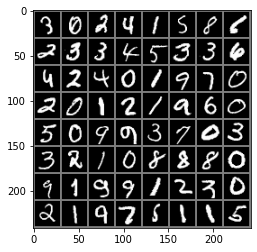

In [15]:
images, labels = next(iter(dataloader))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
print([labels[i] for i in range(64)])
plt.imshow(img)

In [16]:
# image 

channels = 1
img_size = 28

img_shape = (channels, img_size, img_size)

##  Generator

- 생성자는 random vector *'z'*를 입력받아 가짜 이미지를 출력하는 함수입니다. 여기서 'z'는 정규분포(Normal Distribution)에서 무작위로 추출한 값으로, z vector가 존재하는 공간을 잠재공간(latent space)라고 부릅니다.
  - 이 튜토리얼에서는 잠재공간의 크기를 100으로 뒀으며, 잠재공간의 크기에는 제한이 없으나 나타내려고 하는 대상의 정보를 충분히 담을 수 있을 만큼 커야합니다.
- 즉, 생성자는 단순한 분포에서 사람 얼굴 이미지와 같은 복잡한 분포로 mapping하는 함수라고 볼 수 있습니다.
![](images/gan4.png)

- 생성자에 충분히 많은 매개변수를 확보하기 위해 여러개의 layer를 쌓아서 생성자를 만들었습니다.
- [참고](https://dreamgonfly.github.io/blog/gan-explained/)

In [17]:
# dimensionality of the latent space
# latent vector를 추출하기 위한 noise 분포의 dimension (정규분포를 따름)
latent_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # generater의 model은 여러개의 block을 쌓아서 만들어짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh() 
        )

    def forward(self, z): 
        # z : input noise vector 
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

## Discriminator

![](images/gan2.png)

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

## Loss Function & Optimizer

- 손실 함수로는 Binary Cross Entropy를, 최적화 함수로는 Adam을 사용합니다.

In [19]:
''' Hyper parameter '''
# learning rate
lr = 0.0002

# decay of first order momentum of gradient
b1 = 0.5
b2 = 0.999


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Loss function
adversarial_loss = nn.BCELoss()

# Adam Optimizer
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [20]:
# GPU
cuda = True if torch.cuda.is_available() else False

if cuda : 
  generator.cuda()
  discriminator.cuda()
  adversarial_loss.cuda()

# Training

- GAN model에서는 근사적인 추론이나 Markov chains을 사용하지 않고, back-propagation만을 이용하여 gradient를 업데이트합니다.

In [26]:
import time

# number of epochs of training
n_epochs = 200 

# interval between image samples
sample_interval = 2000 

start_time = time.time()

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        ## 실제 이미지는 1로, 가짜 이미지는 0으로 label됩니다. 
        real = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        ## random sampling한 값인 z를 생성자에 넣어 이미지를 생성합니다.
        generated_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        ## 생성된 이미지를 discriminator가 판별하게 한 후, loss값을 계산합니다.
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        ## 실제 이미지는 real(1)로, 가짜 이미지는 fake(0)으로 판별하도록 계산합니다.
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 0/200] [D loss: 0.471759] [G loss: 2.498926] [Elapsed time: 14.76s]
[Epoch 1/200] [D loss: 0.258078] [G loss: 1.360531] [Elapsed time: 29.48s]
[Epoch 2/200] [D loss: 0.506363] [G loss: 0.565381] [Elapsed time: 44.00s]
[Epoch 3/200] [D loss: 0.160770] [G loss: 2.556153] [Elapsed time: 58.55s]
[Epoch 4/200] [D loss: 0.264552] [G loss: 0.989236] [Elapsed time: 73.20s]
[Epoch 5/200] [D loss: 0.133583] [G loss: 2.088663] [Elapsed time: 87.77s]
[Epoch 6/200] [D loss: 0.186072] [G loss: 1.772844] [Elapsed time: 102.10s]
[Epoch 7/200] [D loss: 0.153044] [G loss: 2.998716] [Elapsed time: 116.41s]
[Epoch 8/200] [D loss: 0.232274] [G loss: 2.617228] [Elapsed time: 130.92s]
[Epoch 9/200] [D loss: 0.122365] [G loss: 3.231926] [Elapsed time: 145.17s]
[Epoch 10/200] [D loss: 0.302830] [G loss: 5.149670] [Elapsed time: 159.31s]
[Epoch 11/200] [D loss: 0.175924] [G loss: 1.710651] [Elapsed time: 173.71s]
[Epoch 12/200] [D loss: 1.077994] [G loss: 10.032361] [Elapsed time: 187.91s]
[Epoch 13/200]

## Image

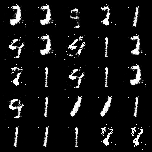

In [33]:
from IPython.display import Image


Image('104000.png')